In [1]:
import torch, PIL, os, torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set

100% 2.33G/2.34G [00:28<00:00, 105MB/s] 
100% 2.34G/2.34G [00:28<00:00, 88.7MB/s]


In [ ]:
!unzip /content/cartoon-faces-googles-cartoon-set.zip

# Hyperparameters

In [9]:
epochs = 10000
batch_size = 32
learning_rate = 1e-4

noise_vector = 200

step = 0
show_step = 87
device = 'cuda'

# Loading Dataset

In [10]:
class Dataset(Dataset):
    def __init__(self):
        super().__init__()
        self.images = []
        self.image_size = 256
        path = "/content/cartoonset100k_jpg/0"
        for image in os.listdir("/content/cartoonset100k_jpg/0"):
            self.images.append(f"{path}/{image}")
    
    
    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, index):
        image = PIL.Image.open(self.images[index])
        image = np.asarray(torchvision.transforms.Resize((self.image_size, self.image_size))(image))
        image = np.transpose(image, (2, 0, 1)).astype(np.float32, copy = False)
        image = torch.from_numpy(image).div(255)
        return image

In [11]:
ds = Dataset()
dataset_iterator = DataLoader(ds, batch_size = batch_size, shuffle = True)

# Show function

In [12]:
def show_images(tensors, num = 10):
    tensor = tensors.detach().cpu()
    grid = make_grid(tensor[:num], nrow = 5).permute(1, 2, 0)
    plt.imshow(grid.clip(0, 1))
    plt.show()

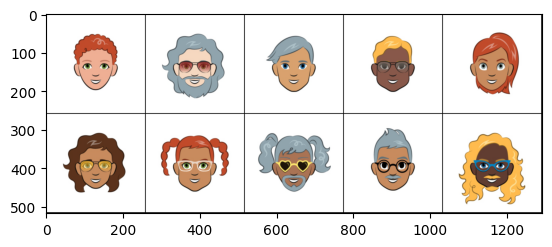

In [13]:
X = next(iter(dataset_iterator))
show_images(X)

# Gradient penalty function

In [14]:
generator_losses = []
discriminator_losses = []

def gradient_penalty(real, fake, discriminator, alpha, gamma = 10):
    mx_images = real * alpha + fake * (1 - alpha)
    mx_scores = discriminator(mx_images)
    
    gradient = torch.autograd.grad(
        inputs = mx_images,
        outputs = mx_scores,
        grad_outputs = torch.ones_like(mx_scores),
        retain_graph = True,
        create_graph = True,
    )[0]
    
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim = 1)
    penalty = gamma * ((gradient_norm - 1)**2).mean()
    
    return penalty

# Generator architecture + vector generating function

In [15]:
class Generator(nn.Module):
    def __init__(self, noise_vector = 200):
        super().__init__()
        self.chan = 16
        self.vec = noise_vector
        self.generator = nn.Sequential(
            # Start with pure noise and and image 1x1
            nn.ConvTranspose2d(self.vec, 64*self.chan, 4, 1, 0), # 4x4
            nn.BatchNorm2d(64*self.chan),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64*self.chan, 32*self.chan, 4, 2, 1), # 8x8
            nn.BatchNorm2d(32*self.chan),
            nn.ReLU(True),

            nn.ConvTranspose2d(32*self.chan, 16*self.chan, 4, 2, 1), # 16x16
            nn.BatchNorm2d(16*self.chan),
            nn.ReLU(True),

            nn.ConvTranspose2d(16*self.chan, 8*self.chan, 4, 2, 1), # 32x32
            nn.BatchNorm2d(8*self.chan),
            nn.ReLU(True),

            nn.ConvTranspose2d(8*self.chan, 4*self.chan, 4, 2, 1), # 64x64
            nn.BatchNorm2d(4*self.chan),
            nn.ReLU(True),

            nn.ConvTranspose2d(4*self.chan, 2*self.chan, 4, 2, 1), # 128x128
            nn.BatchNorm2d(2*self.chan),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(2*self.chan, 3, 4, 2, 1), # 256x256
            nn.Tanh()
        )
    
    def forward(self, vec):
        x = vec.view(len(vec), self.vec, 1, 1)
        return self.generator(x)

In [16]:
def generate_new_vector(bs_size, vec = 200):
    return torch.randn(bs_size, vec ,device = device)

# Discriminator architecture

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.chan = 16
        self.discriminator = nn.Sequential(
            # Start with image 256
            nn.Conv2d(3, self.chan*2, 4, 2, 1), # 128x128
            nn.InstanceNorm2d(self.chan*2),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(self.chan*2, self.chan*4, 4, 2, 1), # 64x64
            nn.InstanceNorm2d(self.chan*4),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(self.chan*4, self.chan*8, 4, 2, 1), # 32x32
            nn.InstanceNorm2d(self.chan*8),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(self.chan*8, self.chan*16, 4, 2, 1), # 16x16
            nn.InstanceNorm2d(self.chan*16),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(self.chan*16, self.chan*32, 4, 2, 1), # 8x8
            nn.InstanceNorm2d(self.chan*32),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(self.chan*32, self.chan*64, 4, 2, 1), # 4x4
            nn.InstanceNorm2d(self.chan*64),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(self.chan*64, 1, 4, 1, 0), # 1x1
        )
    
    def forward(self, image):
        img = self.discriminator(image)
        return img.view(len(img), -1)

# Optimizers, loss function lists, generator and discriminator initialization

In [18]:
generator_losses = []
discriminator_losses = []

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optim = Adam(generator.parameters(), lr = learning_rate, betas = (0.5, 0.9))
discriminator_optim = Adam(discriminator.parameters(), lr = learning_rate, betas = (0.5, 0.9))

In [19]:
checkpoint = torch.load("/content/drive/MyDrive/C.pkl")
discriminator.load_state_dict(checkpoint["model_state_dict"])
discriminator_optim.load_state_dict(checkpoint["optimizer_state_dict"])

checkpoint = torch.load("/content/drive/MyDrive/G.pkl")
generator.load_state_dict(checkpoint["model_state_dict"])
generator_optim.load_state_dict(checkpoint["optimizer_state_dict"])

# Main training loop

In [38]:
for epoch in range(epochs):
    for X in tqdm(dataset_iterator):
        current_batch = len(X)
        X = X.to(device)
        
        mean_discriminator_loss = 0
        discriminator_optim.zero_grad()
        nvec = generate_new_vector(current_batch)
        fake = generator(nvec)
        preds = discriminator(fake.detach())
        real_preds = discriminator(X)
            
        alpha = torch.rand(len(X), 1, 1, 1, device = device, requires_grad = True)
        penalty = gradient_penalty(X, fake.detach(), discriminator, alpha)
            
        discriminator_loss = preds.mean() - real_preds.mean() + penalty
            
        mean_discriminator_loss += discriminator_loss.item()
            
        discriminator_loss.backward(retain_graph = True)
        discriminator_optim.step()
        
        discriminator_losses += [mean_discriminator_loss]
        
        generator_optim.zero_grad()
        nvec = generate_new_vector(current_batch)
        fake = generator(nvec)
        discriminator_preds = discriminator(fake)
        
        generator_loss = -discriminator_preds.mean()
        generator_loss.backward()
        generator_optim.step()
        
        generator_losses += [generator_loss]
        
        if(step % show_step == 0 and step != 0):
            
            torch.save({
                  'epoch': epoch,
                  'model_state_dict': generator.state_dict(),
                  'optimizer_state_dict': generator_optim.state_dict()
              }, "/content/drive/MyDrive/G.pkl")

            torch.save({
                  'epoch': epoch,
                  'model_state_dict': discriminator.state_dict(),
                  'optimizer_state_dict': discriminator_optim.state_dict()
              }, f"/content/drive/MyDrive/C.pkl")
            
            show_images(fake)
            show_images(X)

            generator_mean = sum(generator_losses[-show_step:]) / show_step
            discriminator_mean = sum(discriminator_losses[-show_step:]) / show_step
            print(f"Epoch: {epoch}, Step: {step}, GEN loss: {generator_mean}, DISC: {discriminator_mean}")
            plt.plot(
                range(len(generator_losses)),
                torch.Tensor(generator_losses),
                label = "Generator Loss"
            )

            plt.plot(
                range(len(discriminator_losses)),
                torch.Tensor(discriminator_losses),
                label ="Critic Loss"
            )

            plt.ylim(-1000, 1000)
            plt.legend()
            plt.show()
        
        step += 1

  0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

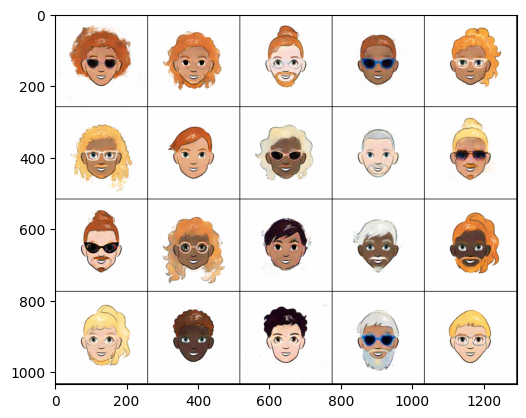

In [39]:
new_vector = generate_new_vector(128)
images = generator(new_vector)
show_images(images, 20)